# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [3]:
df[['email','article_id']].groupby(['email']).count()['article_id']

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
0042719415c4fca7d30bd2d4e9d17c5fc570de13     2
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7     3
008ba1d5b4ebf54babf516a2d5aa43e184865da5    10
008ca24b82c41d513b3799d09ae276d37f92ce72     1
008dfc7a327b5186244caec48e0ab61610a0c660    13
009af4e0537378bf8e8caf0ad0e2994f954d822e     1
00bda305223d05f6df5d77de41abd2a0c7d895fe     4
00c2d5190e8c6b821b0e3848bf56f6e47e428994     3
00ced21f957bbcee5edf7b107b2bd05628b04774     4
00d9337ecd5f70fba1c4c7a78e21b3532e0112c4     3
00e524e4f13137a6fac54f9c71d7769c6507ecde    11
00f8341cbecd6af00ba8c78b3bb6ec49adf83248     3
00f946b14100f0605fa25089437ee9486378872c     1
01041260c97ab9221d923b0a2c525437f148d589     2
0108ce3220657a9a89a85bdec959b0f2976dd51c     4
011455e91a24c1fb815a4deac6b6eaf5ad16819e     9
01198c5

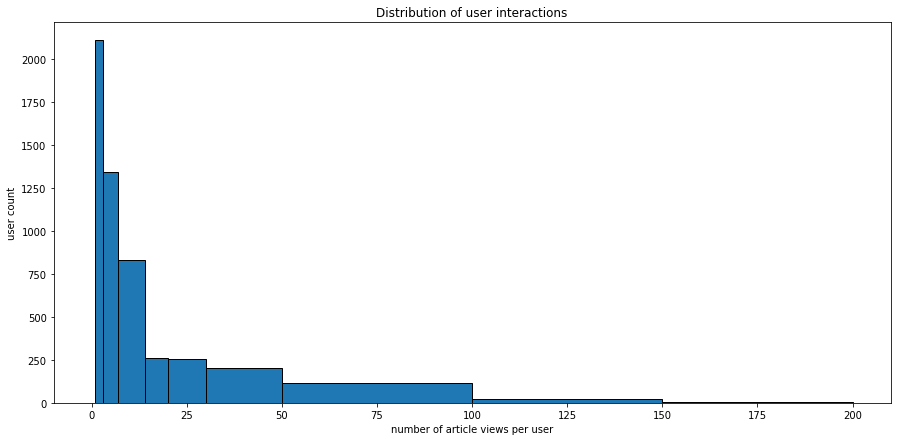

In [4]:
hist_bins = [0,1,3,7,14,20,30,50,100,150,200]
plt.figure(figsize=(15,7))
plt.hist(df[['email','article_id']].groupby(['email']).count()['article_id'],bins=hist_bins,histtype='bar',ec='black')
plt.title('Distribution of user interactions')
plt.xlabel('number of article views per user')
plt.ylabel('user count')
plt.show()

In [5]:
df[['email','article_id']].groupby(['email']).count().describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [6]:
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
duplicates = df_content.duplicated(subset=['article_id'])
duplicate_article_ids = df_content['article_id'][duplicates]
duplicate_article_names = df_content['doc_full_name'][duplicates]
print('Duplicated article IDs: {}'.format(duplicate_article_ids.values))
print('Duplicated article names: {}'.format(duplicate_article_names.values))

Duplicated article IDs: [ 50 221 398 577 232]
Duplicated article names: ['Graph-based machine learning'
 'How smart catalogs can turn the big data flood into an ocean of opportunity'
 'Using Apache Spark as a parallel processing framework for accessing REST based data services'
 'Use the Primary Index'
 'Self-service data preparation with IBM Data Refinery']


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'],keep='first')

In [9]:
print('The number of unique articles that have an interaction with a user: {}'.format(len(df['article_id'].unique())))
print('The number of unique articles in the dataset (whether they have any interactions or not): {}'.format(len(df_content['article_id'].unique())))
print('The number of unique users in the dataset. (excluding null values): {}'.format(len(df['email'].unique())))
print('The number of user-article interactions in the dataset: {}'.format(df.shape[0]))

The number of unique articles that have an interaction with a user: 714
The number of unique articles in the dataset (whether they have any interactions or not): 1051
The number of unique users in the dataset. (excluding null values): 5149
The number of user-article interactions in the dataset: 45993


In [10]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` To find the most viewed **article_id**, as well as how often it was viewed.

In [11]:
df.groupby('article_id').count()['email'].nlargest(1)

article_id
1429.0    937
Name: email, dtype: int64

In [12]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [13]:
# map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In [14]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_IDs = df.groupby('article_id').count()['user_id'].nlargest(n).index

    top_articles = list(df[df['article_id'].isin(top_IDs)]['title'].unique())
    
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list(df.groupby('article_id').count()['user_id'].nlargest(n).index)
    
 
    return top_articles 

In [15]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformating the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    user_item = user_item.fillna(0)
    for col in user_item.columns:
            user_item[col] = user_item[col].apply(lambda x: x if x == 0 else 1)
            
    return user_item 

user_item = create_user_item_matrix(df)

In [17]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [18]:
user_similarity = np.dot(user_item,user_item.T)
pd.DataFrame(user_similarity, index=range(1, user_similarity.shape[0]+1), columns=range(1, user_similarity.shape[0]+1))

,1,2,3,4,5,6,7,8,9,10,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
1,36.0,2.0,6.0,3.0,0.0,4.0,1.0,6.0,4.0,7.0,...,7.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,6.0,1.0,3.0,0.0,2.0,0.0,1.0,2.0,4.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6.0,1.0,40.0,5.0,1.0,7.0,1.0,5.0,2.0,5.0,...,7.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0
4,3.0,3.0,5.0,26.0,3.0,8.0,0.0,8.0,1.0,4.0,...,6.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0
5,0.0,0.0,1.0,3.0,3.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,2.0,7.0,8.0,1.0,18.0,1.0,6.0,1.0,4.0,...,4.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6.0,1.0,5.0,8.0,3.0,6.0,0.0,57.0,6.0,9.0,...,8.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
9,4.0,2.0,2.0,1.0,0.0,1.0,0.0,6.0,30.0,4.0,...,11.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
10,7.0,4.0,5.0,4.0,0.0,4.0,1.0,9.0,4.0,19.0,...,5.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user

    # sort by similarity

    # create list of just the ids
   
    user_similarity=np.dot(user_item,user_item.T)
    user_similarity=pd.DataFrame(user_similarity, index=range(1, user_similarity.shape[0]+1), columns=range(1, user_similarity.shape[0]+1))
    user_similarity=user_similarity.loc[user_id,]
    user_similarity=user_similarity.drop(user_id)
    
    # Identify most similar user
    most_similar_users=user_similarity.sort_values(ascending=False).index.tolist() 
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [20]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that above function provides the most similar users to each user, the functions below return the articles we would recommend to each user. 

In [21]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = user_item.columns[list(user_item.loc[user_id,] == 1)]
    article_ids = article_ids.astype(str)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    user_article_ids, user_article_names = get_user_articles(user_id)
    recs = list()
    for similar_user_id in most_similar_users:
        if len(recs)<m:
            similar_article_ids, similar_article_names = get_user_articles(similar_user_id)
            new_recs = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
            recs.append(new_recs)
            recs = [item for sublist in recs for item in sublist]
        else:
            break
        
    recs = recs[:m]
    
    return recs 

In [22]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df=pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    
    user_similarity=np.dot(user_item,user_item.T)

    
    user_similarity=pd.DataFrame(user_similarity, index=range(1, user_similarity.shape[0]+1), columns=range(1, user_similarity.shape[0]+1))
    user_similarity=user_similarity.loc[user_id].drop(user_id)
    
    neighbors_df.neighbor_id=user_similarity.index
    neighbors_df.index=user_similarity.index
    neighbors_df.similarity=user_similarity
    neighbors_df.num_interactions=df.groupby('user_id').count().sort_values('title',ascending=False).drop(user_id)
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False) 
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    recs = []
    i = 1
    top_articles_ids = []
    
    most_similar_users = get_top_sorted_users(user_id)
    list_article_read = get_user_articles(user_id)[0]
    
    while len(recs) < m:
        list_similar_read = get_user_articles(i)[0]
        
    # ordered by most interactions   
        df_by_article_ids = df[df['article_id'].isin(list_similar_read)].groupby('article_id').count()
        df_by_article_ids_sorted = df_by_article_ids.sort_values('title',ascending=False)['title']
    
        for j in range(0,df_by_article_ids_sorted.shape[0]):
            top_articles_ids.append(df_by_article_ids_sorted.index[j])   
            
        notread = list(set(top_articles_ids) - set(list_article_read))
        recommend = list(set(notread) - set(recs))
    # add the new recommendations to the recommendation list
        recs.extend(recommend)
        recs = list(set(recs))
        i +=1
        if i > len(most_similar_users):
            break
        else :
            pass
    
    # add random article to the recommandation list if < m or cut if too many article
    if len(recs)<m :
        recs.extend(get_top_article_ids(m-len(recs)))
        recs = recs[:m]
    if len(recs) == m:
        recs = recs
    elif len(recs) > m:
        recs = recs[:m]
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [24]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[768.0, 390.0, 268.0, 1293.0, 910.0, 525.0, 1170.0, 1427.0, 1429.0, 1430.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'finding optimal locations of new store using decision optimization', 'sector correlations shiny app', 'new shiny cheat sheet and video tutorial', 'python if statements explained (python for data science basics #4)', 'working with ibm cloud object storage in python', 'introducing ibm watson studio ']


In [25]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131

In [26]:
user1_most_sim

3933

In [27]:
user131_10th_sim

242

`5.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?

**Response**

I believe the function get_top_article_ids(10), so that the new user receive the top 10 of the most interacted articles among the whole user base. Since we are providing a list of the most viewed articles by the whole community so we cannot consider it as the best solution.

`6.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [28]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = list(map(str,get_top_article_ids(10))) # Your recommendations here


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [29]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [30]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`1.` Using Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [31]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(a=user_item_matrix)
# use the built in to get the three matrices

`2.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

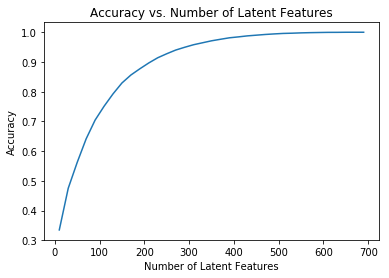

In [32]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`3.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Using the code from question 2 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [33]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [34]:
len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique()))

20

In [35]:
len(df_test.user_id.unique()) - len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique()))

662

In [36]:
len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique()))

574

In [37]:
len(df_test.article_id.unique()) - len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique()))

0

`4.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [38]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [39]:
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

In [40]:
user_item_test_reduced = user_item_test.loc[user_item_train.index.intersection(test_idx), user_item_train.columns.intersection(test_arts)]

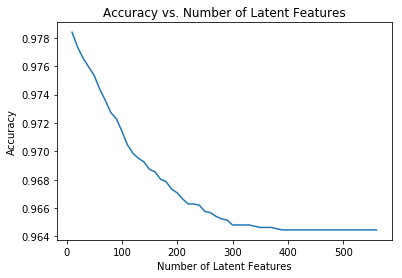

In [41]:
num_latent_feats = np.arange(10,570,10)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    s_test_k, u_test_k, vt_test_k = s_train_k, u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_test_subset_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_reduced, user_item_test_subset_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


n_interactions_reduced = user_item_test_reduced.shape[0]*user_item_test_reduced.shape[1]
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/n_interactions_reduced);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`5.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Response**

1. I'd probably be making an evaluation metrics and if the precision and recall didn't show up well, I'd be going for an ensemble of the techniques learnt during this module.
2. The accuracy poorly represents the ability to correcly predict if the user saw a movie or not due to the unbalanced classes.
3. Here we can make predictions for just 20 users, which seems to be a problem. A solution to this could be a larger dataset.
4. A/B Testing could be used here which could improve the results a bit. This could be done randomly assigning each user to one of the two groups. One group has the old page suggestions for articles according to the "old" reccomendation engine. The second group interacts with the same page provided by the new reccomendation engine. Based on this, (Number of clicks-on-reccomendations / Number of cookies) metric seems to be a good approach.